In [15]:
import spacy
from nltk.corpus import stopwords
import gensim
import pandas as pd
from datasets import load_dataset
import nltk
from nltk.tokenize import sent_tokenize
import pickle
import spacy.cli
from nltk.stem import WordNetLemmatizer

spacy.cli.download("en_core_web_lg")
nltk.download('punkt')  # Download the Punkt tokenizer models
nltk.download('stopwords')
nltk.download('wordnet')

def load_wikipedia_to_dataframe(split='train'):
    """Load Wikipedia dataset and convert it to DataFrame."""
    dataset = load_dataset("wikipedia", "20220301.simple", split=split)
    df = pd.DataFrame(dataset)
    return df

stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_lg')

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    def remove_stopwords(text):
        return [word for word in text if word not in stop_words]

    def lemmatize(text):
        return [lemmatizer.lemmatize(word) for word in text]


    tokenized_text = gensim.utils.simple_preprocess(text, deacc=True)
    no_stopwords = remove_stopwords(tokenized_text)
    lemmatized = lemmatize(no_stopwords)
    return lemmatized

def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
wiki_articles_df = load_wikipedia_to_dataframe()
print("data loaded")
wiki_articles_df.head()

data loaded


,id,url,title,text
0,1,https://simple.wikipedia.org/wiki/April,April,April is the fourth month of the year in the J...
1,2,https://simple.wikipedia.org/wiki/August,August,August (Aug.) is the eighth month of the year ...
2,6,https://simple.wikipedia.org/wiki/Art,Art,Art is a creative activity that expresses imag...
3,8,https://simple.wikipedia.org/wiki/A,A,A or a is the first letter of the English alph...
4,9,https://simple.wikipedia.org/wiki/Air,Air,Air refers to the Earth's atmosphere. Air is a...


In [17]:

# Filtering out texts with less than 8 sentences
filtered_df = wiki_articles_df[wiki_articles_df['text'].apply(count_sentences) >= 8]


del wiki_articles_df

In [18]:
from dask.distributed import Client

client = Client(n_workers=24)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 48,Total memory: 63.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64150,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 63.76 GiB
Comm: tcp://127.0.0.1:64283,Total threads: 2
Dashboard: http://127.0.0.1:64292/status,Memory: 2.66 GiB
Nanny: tcp://127.0.0.1:64153,


In [19]:
import dask.dataframe as dd
import pandas as pd
from dask.multiprocessing import get
from dask import delayed, compute

# Assuming other imports and functions from the previous code snippet are already here.

# Convert the filtered pandas dataframe to a dask dataframe with partitions
# You can adjust the number of partitions as per your system's memory and CPU capabilities
dask_df = dd.from_pandas(filtered_df, npartitions=10)

# Applying the preprocess function to each partition
# Dask's map_partitions will apply the delayed_preprocess to each partition
result = dask_df['text'].map_partitions(lambda df: df.apply(lambda x: preprocess(x)), meta='object')

# Now, compute the result
# This step will trigger the parallel computation
results = result.compute(scheduler='processes')

# Assign the results to a new column in the original dataframe
filtered_df['processed_text'] = results

# To save this dataframe, you can use to_csv, to_parquet or any suitable format.
filtered_df.to_parquet('processed_wiki_articles.parquet', index=False)



c:\Users\chris\AppData\Local\anaconda3\envs\gensim\lib\site-packages\dask\dataframe\core.py:7234: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
c:\Users\chris\AppData\Local\anaconda3\envs\gensim\lib\site-packages\dask\base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
c:\Users\chris\AppData\Local\anaconda3\envs\gensim\lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [20]:
filtered_df["processed_text"].head(5)

0    [april, fourth, month, year, julian, gregorian...
1    [august, aug, eighth, month, year, gregorian, ...
2    [art, creative, activity, express, imaginative...
3    [first, letter, english, alphabet, small, lett...
4    [air, refers, earth, atmosphere, air, mixture,...
Name: processed_text, dtype: object

In [21]:
import pandas as pd
df= pd.read_parquet("processed_wiki_articles.parquet")
df.head(5)

,id,url,title,text,processed_text
0,1,https://simple.wikipedia.org/wiki/April,April,April is the fourth month of the year in the J...,"[april, fourth, month, year, julian, gregorian..."
1,2,https://simple.wikipedia.org/wiki/August,August,August (Aug.) is the eighth month of the year ...,"[august, aug, eighth, month, year, gregorian, ..."
2,6,https://simple.wikipedia.org/wiki/Art,Art,Art is a creative activity that expresses imag...,"[art, creative, activity, express, imaginative..."
3,8,https://simple.wikipedia.org/wiki/A,A,A or a is the first letter of the English alph...,"[first, letter, english, alphabet, small, lett..."
4,9,https://simple.wikipedia.org/wiki/Air,Air,Air refers to the Earth's atmosphere. Air is a...,"[air, refers, earth, atmosphere, air, mixture,..."


In [22]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline

data_lemmatized = df["processed_text"]
data_lemmatized.head(2)



# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

import csv
import gensim
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm

def optimize_lda(corpus, id2word, data_lemmatized, topics_range, passes, output_csv):
    best_model = None
    best_coherence = float('-inf')
    results = []

    print("Starting LDA optimization over topics range...")

    for num_topics in tqdm(topics_range, desc='Optimizing LDA'):
        # Create an LDA model
        print(f"\nTraining LDA model with {num_topics} topics...")
        lda_model = LdaModel(corpus=corpus,
                             id2word=id2word,
                             num_topics=num_topics,
                             passes=passes,alpha='auto',eta="auto")

        # Compute perplexity
        perplexity = lda_model.log_perplexity(corpus)
        print(f"Computed perplexity for {num_topics} topics: {perplexity:.4f}")

        # Compute coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence = coherence_model.get_coherence()
        print(f"Computed coherence for {num_topics} topics: {coherence:.4f}")

        # Update results
        results.append({
            'num_topics': num_topics,
            'perplexity': perplexity,
            'coherence': coherence
        })

        # Save the model if it has the best coherence so far
        if coherence > best_coherence:
            best_coherence = coherence
            best_model = lda_model
            print("New best model found and saved with coherence:", best_coherence)

    # Write results to a CSV file
    print("\nSaving results to CSV...")
    with open(output_csv, 'w', newline='') as csvfile:
        fieldnames = ['num_topics', 'perplexity', 'coherence']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for result in results:
            writer.writerow(result)
    
    print(f"Results saved to {output_csv}")

    # Save the best model to disk
    best_model.save('best_lda_model')
    print("Best LDA model saved to disk.")

    return results, best_model

# Example usage:
results, best_lda_model = optimize_lda(corpus=corpus, id2word=id2word, data_lemmatized=data_lemmatized, 
                                       topics_range=range(20, 100, 10), passes=20, 
                                       output_csv='lda_optimization_results.csv')



[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 2), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 2), (17, 1), (18, 1), (19, 5), (20, 2), (21, 1), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 1), (28, 208), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 4), (36, 3), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 2), (45, 2), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 13), (60, 1), (61, 5), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 9), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 3), (96, 2), (97, 1), (98, 1), (99, 2), (100, 1), (101, 2), (102, 1), (103, 2), (104, 1), (105, 1), (106, 1), (107, 1), (108, 2), (109, 1), (110,

Optimizing LDA:   0%|          | 0/8 [00:00<?, ?it/s]


Training LDA model with 20 topics...
Computed perplexity for 20 topics: -10.3398


Optimizing LDA:  12%|█▎        | 1/8 [28:21<3:18:27, 1701.00s/it]

Computed coherence for 20 topics: 0.5748
New best model found and saved with coherence: 0.5748416419775333

Training LDA model with 30 topics...
Computed perplexity for 30 topics: -11.1554


Optimizing LDA:  25%|██▌       | 2/8 [1:25:54<4:33:12, 2732.02s/it]

Computed coherence for 30 topics: 0.5802
New best model found and saved with coherence: 0.5801987139401035

Training LDA model with 40 topics...
Computed perplexity for 40 topics: -12.0135


Optimizing LDA:  38%|███▊      | 3/8 [3:18:13<6:20:06, 4561.36s/it]

Computed coherence for 40 topics: 0.6125
New best model found and saved with coherence: 0.6125190213425158

Training LDA model with 50 topics...
Computed perplexity for 50 topics: -12.8957


Optimizing LDA:  50%|█████     | 4/8 [6:05:21<7:27:58, 6719.53s/it]

Computed coherence for 50 topics: 0.6065

Training LDA model with 60 topics...
Computed perplexity for 60 topics: -13.7466


Optimizing LDA:  62%|██████▎   | 5/8 [9:17:40<7:02:53, 8457.76s/it]

Computed coherence for 60 topics: 0.6067

Training LDA model with 70 topics...
Computed perplexity for 70 topics: -14.6557


Optimizing LDA:  75%|███████▌  | 6/8 [10:58:38<4:14:43, 7641.85s/it]

Computed coherence for 70 topics: 0.6291
New best model found and saved with coherence: 0.6291236911291271

Training LDA model with 80 topics...
Computed perplexity for 80 topics: -15.5664


Optimizing LDA:  88%|████████▊ | 7/8 [13:49:44<2:21:39, 8499.78s/it]

Computed coherence for 80 topics: 0.5984

Training LDA model with 90 topics...
Computed perplexity for 90 topics: -16.4247


Optimizing LDA: 100%|██████████| 8/8 [18:46:50<00:00, 8451.36s/it]  

Computed coherence for 90 topics: 0.5994

Saving results to CSV...
Results saved to lda_optimization_results.csv


Best LDA model saved to disk.


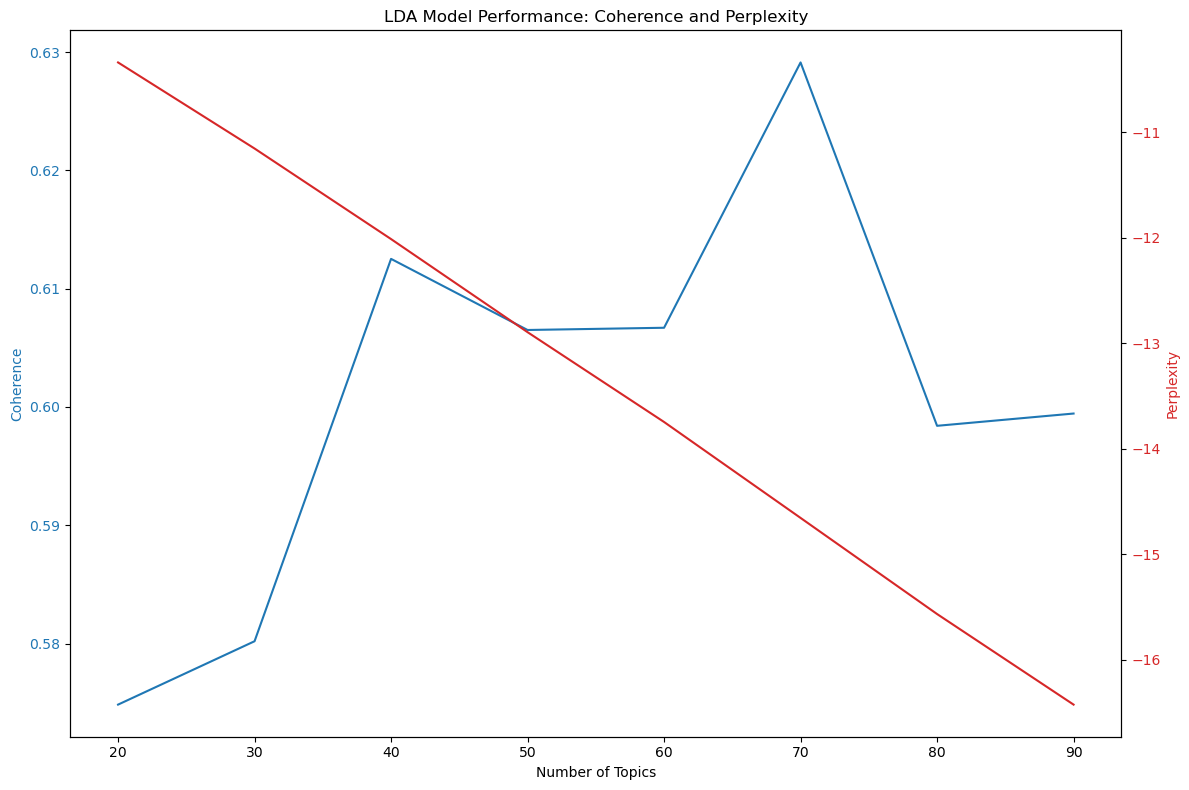

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('lda_optimization_results.csv')

# Plotting the coherence and perplexity scores as a function of the number of topics
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot coherence
color = 'tab:blue'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence', color=color)
ax1.plot(df['num_topics'], df['coherence'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

# Plot perplexity on the same graph but with a different y-axis
color = 'tab:red'
ax2.set_ylabel('Perplexity', color=color)
ax2.plot(df['num_topics'], df['perplexity'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
plt.title('LDA Model Performance: Coherence and Perplexity')
fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.show()


In [19]:
import gensim
import numpy as np
from gensim.models.ldamulticore import LdaMulticore
import pandas as pd
import numpy as np
import gensim
from gensim.matutils import cossim
import random
import gensim.corpora as corpora
from gensim.corpora import Dictionary

df= pd.read_parquet("processed_wiki_articles.parquet")
data_lemmatized = df["processed_text"]


# Load id2word
id2word = Dictionary.load('lda.model.id2word')


# # Create Corpus if it doesnt exist
# texts = data_lemmatized  
# # Term Document Frequency 
# corpus = [id2word.doc2bow(text) for text in texts]  
# corpora.MmCorpus.serialize('corpus.mm', corpus)



corpus = corpora.MmCorpus('corpus.mm')
lda_model = LdaMulticore.load('best_lda_model')

topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)
df["lda_vector"]=topic_distributions

In [20]:
df.head()

,id,url,title,text,processed_text,lda_vector
0,1,https://simple.wikipedia.org/wiki/April,April,April is the fourth month of the year in the J...,"[april, fourth, month, year, julian, gregorian...","[(0, 0.0036353962), (1, 0.0046631563), (2, 0.0..."
1,2,https://simple.wikipedia.org/wiki/August,August,August (Aug.) is the eighth month of the year ...,"[august, aug, eighth, month, year, gregorian, ...","[(0, 2.816133e-05), (1, 0.0012392161), (2, 4.6..."
2,6,https://simple.wikipedia.org/wiki/Art,Art,Art is a creative activity that expresses imag...,"[art, creative, activity, express, imaginative...","[(0, 4.6453028e-05), (1, 4.1981748e-05), (2, 7..."
3,8,https://simple.wikipedia.org/wiki/A,A,A or a is the first letter of the English alph...,"[first, letter, english, alphabet, small, lett...","[(0, 0.0064519555), (1, 0.00014702255), (2, 0...."
4,9,https://simple.wikipedia.org/wiki/Air,Air,Air refers to the Earth's atmosphere. Air is a...,"[air, refers, earth, atmosphere, air, mixture,...","[(0, 8.632992e-05), (1, 7.802034e-05), (2, 0.0..."


In [21]:
df2= pd.read_pickle("augmented_data.pkl")
df2.head(2)

,id,embedding,medoids,cluster_sizes
0,1,"[[-0.0019472323, 0.058371827, 0.0812831, 0.030...","[[-0.004593551, 0.051833656, -0.013445671, -0....","[10, 7, 9, 1]"
1,2,"[[0.01151042, -0.021297293, -0.004139077, 0.03...","[[0.004454516, 0.011180584, 0.053998474, -0.02...","[6, 2, 5, 1]"


In [22]:
# Perform inner join on 'id' column
merged_df = pd.merge(df, df2[['id']], on='id', how='inner')
len(merged_df.index)
merged_df.to_pickle("merged_df_lda.pkl")

In [6]:
import numpy as np
import random
from gensim.matutils import cossim
import pandas as pd
merged_df= pd.read_pickle("merged_df_lda.pkl")

def sample_triplets(df, num_samples=1000, pos_threshold=0.6, neg_threshold=0.3, required_matches=10):
    # Initialize lists to collect positive and negative indices
    positive_indices = []
    negative_indices = []
    
    # Keep sampling until we have enough positives and negatives
    while len(positive_indices) < required_matches or len(negative_indices) < required_matches:
        anchor_idx = random.randint(0, len(df) - 1)
        anchor_id = df.iloc[anchor_idx]['id']
        anchor_vec = df.iloc[anchor_idx]['lda_vector']

        df_remaining = df.drop(anchor_idx).reset_index(drop=True)
        sampled_indices = np.random.choice(df_remaining.index, size=num_samples, replace=False)

        for idx in sampled_indices:
            similarity = cossim(anchor_vec, df_remaining.iloc[idx]['lda_vector'])

            # Add index to positives or negatives if it meets the threshold criteria
            if similarity > pos_threshold and len(positive_indices) < required_matches:
                positive_indices.append((idx, similarity))
            elif similarity < neg_threshold and len(negative_indices) < required_matches:
                negative_indices.append((idx, similarity))

        # Optionally print progress
        #print(f"Collected positives: {len(positive_indices)}, negatives: {len(negative_indices)}")

    # Randomly select one positive and one negative from the collected samples
    positive_idx = random.choice(positive_indices)[0]
    negative_idx = random.choice(negative_indices)[0]

    # Get the IDs for the positive and negative documents
    positive_id = df_remaining.iloc[positive_idx]['id']
    negative_id = df_remaining.iloc[negative_idx]['id']
    
    return anchor_id, positive_id, negative_id

# Assuming merged_df is your dataframe with lda_vectors
# Example usage
triplet = sample_triplets(merged_df)
print(triplet)


('700807', '274287', '427541')


In [7]:
# Retrieve the document details based on the triplet IDs
def retrieve_documents(df, triplet):
    anchor_id, positive_id, negative_id = triplet
    
    # Retrieve the rows for the anchor, positive, and negative documents
    anchor_doc = df.loc[df['id'] == anchor_id]
    positive_doc = df.loc[df['id'] == positive_id]
    negative_doc = df.loc[df['id'] == negative_id]
    
    return anchor_doc, positive_doc, negative_doc

# Get the documents for the triplet
anchor_doc, positive_doc, negative_doc = retrieve_documents(merged_df, triplet)

# Display the document details
print("Anchor Document:\n", anchor_doc)
print("\nPositive Document:\n", positive_doc)
print("\nNegative Document:\n", negative_doc)



Anchor Document:
            id                                     url title  \
14031  700807  https://simple.wikipedia.org/wiki/Reol  Reol   

                                                    text  \
14031  is a Japanese female singer, songwriter, recor...   

                                          processed_text  \
14031  [japanese, female, singer, songwriter, record,...   

                                              lda_vector  
14031  [(0, 0.00012298489), (1, 0.00011114712), (2, 0...  

Positive Document:
           id                                          url      title  \
8905  274287  https://simple.wikipedia.org/wiki/Auto-Tune  Auto-Tune   

                                                   text  \
8905  Auto-Tune is a proprietary audio processor mad...   

                                         processed_text  \
8905  [auto, tune, proprietary, audio, processor, ma...   

                                             lda_vector  
8905  [(0, 4.326017e-05), (1, 3.9

In [8]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to run sampling in parallel
def run_sampling_in_parallel(df, num_triplets, pos_threshold, neg_threshold, num_threads):
    # Function to execute in each thread
    def thread_function(df):
        return sample_triplets(df,1000,pos_threshold,neg_threshold)

    triplets = []
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Schedule the callable 'thread_function' to be executed 'num_triplets' times
        future_to_triplet = {executor.submit(thread_function, df): i for i in range(num_triplets)}
        
        for future in as_completed(future_to_triplet):
            try:
                # Get the result from the future
                triplet = future.result()
                triplets.append(triplet)
            except Exception as exc:
                print(f'Generated an exception: {exc}')

    return triplets


# num_triplets = 30000
# num_threads = 10
# triplets = run_sampling_in_parallel(merged_df, num_triplets, num_threads)

# Concatenating the results - in this case, 'triplets' is already a list of results
# If you need to concatenate data from each thread, you could modify the list accordingly
# print("Created Triplets")


In [9]:

import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

# Assume cossim function and other necessary imports are already defined.



    # Your run_sampling_in_parallel code modified to pass the thresholds...

def run_sampling_multiple_times(df, sampling_parameters, num_threads):
    all_triplets = []  # This will hold all the triplets from each run

    for params in sampling_parameters:
        num_triplets = params['num_triplets']
        pos_threshold = params['pos_threshold']
        neg_threshold = params['neg_threshold']

        print(f"Running sampling with {num_triplets} triplets, positive threshold {pos_threshold}, and negative threshold {neg_threshold}")
        triplets = run_sampling_in_parallel(df, num_triplets, pos_threshold, neg_threshold, num_threads)
        
        # Add the triplets from this run to the overall list
        all_triplets.extend(triplets)

    return all_triplets

# Define your sampling parameters as a list of dictionaries before running the function
sampling_parameters = [
    {'num_triplets': 10000, 'pos_threshold': 0.6, 'neg_threshold': 0.4},
    {'num_triplets': 10000, 'pos_threshold': 0.6, 'neg_threshold': 0.4},
    {'num_triplets': 10000, 'pos_threshold': 0.6, 'neg_threshold': 0.4},
    {'num_triplets': 10000, 'pos_threshold': 0.6, 'neg_threshold': 0.4},
    {'num_triplets': 10000, 'pos_threshold': 0.6, 'neg_threshold': 0.4}
]

num_threads = 10  # Or whatever number of threads you want to use
all_results = run_sampling_multiple_times(merged_df, sampling_parameters, num_threads)

# Now all_results will contain all the triplets sampled for each run with the respective parameters


Running sampling with 10000 triplets, positive threshold 0.6, and negative threshold 0.4
Running sampling with 10000 triplets, positive threshold 0.6, and negative threshold 0.4
Running sampling with 10000 triplets, positive threshold 0.6, and negative threshold 0.4
Running sampling with 10000 triplets, positive threshold 0.6, and negative threshold 0.4
Running sampling with 10000 triplets, positive threshold 0.6, and negative threshold 0.4


In [10]:
import pickle
with open('tripletIds.pickle', 'wb') as f:
    pickle.dump(all_results, f)

print(f"Saved {len(all_results)} triplets to 'tripletIds.pickle'")

Saved 50000 triplets to 'tripletIds.pickle'
